# Notebook to get expected and actual distribution per chromosome arm of target regulon genes

In [1]:
import pandas as pd
import pyranges as pr
import pybiomart as pbm
import numpy as np
import matplotlib.pyplot as plt
import os
import mudata
from collections import Counter
from scipy.stats import chisquare


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
# get all genes + their chrom bands
dataset = pbm.Dataset(name="hsapiens_gene_ensembl", host="http://www.ensembl.org")

genes = dataset.query(
        attributes=[
            "chromosome_name",
            "start_position",
            "end_position",
            "external_gene_name",
            "band"
        ]
    )
genes.rename(columns={"Chromosome/scaffold name": "Chromosome", "Gene start (bp)": "Start", "Gene end (bp)": "End"}, inplace=True)
genes['Karyotype band'] = genes['Karyotype band'].str.replace(r'[\d\W]+', '', regex=True)
genes['chr_arm'] = genes['Chromosome'] + '_' + genes['Karyotype band']

In [3]:
os.chdir(os.getcwd())

In [4]:
scplus_mdata = mudata.read("subset/outs/scplusmdata.h5mu")

/opt/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warning

In [5]:
scplus_mdata

MuData object with n_obs × n_vars = 4178 × 208151
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	4178 x 36601
      obs:	'sample', 'dna_total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'outlier', 'mt_outlier', 'ribo_outlier', 'doublet_outlier', 'leiden', 'leiden_0.05', 'leiden_0.5', 'leiden_0.6', 'leiden_0.75', 'leiden_0.8', 'leiden_0.85', 'leiden_0.9', 'leiden_0.95', 'leiden_1.0', 'leiden_1.25', 'leiden_1.5', 'leiden_2.0', 'leiden_5.0', 'leiden_10.0', 'leiden_20.0', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'base_index'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      obsm:	'X_pca', 'X_umap'
    scATAC_counts:	4178 x 171458
      obs:	'log10_total_fragments_count', 'cisTopic_log_nr_frag', 'pycisTopic_leiden_10_1.2', 'pdf_values_for_duplication_ratio', 'barcode', 'pycisTopic_leiden_10_0.6', 'log10_unique_fragments_in_peaks_count', 'duplication_count', 'cisTopic_nr_frag', 'cisTopic_nr_acc', 'sample_id', 'unique_fragments_in_peaks_count', 'cell_type_all', 'log10_total_fragments_in_peaks_count', 'duplication_ratio', 'tss_enrichment', 'fraction_of_fragments_in_peaks', 'barcode_rank', 'pycisTopic_leiden_10_0.2', 'cell_type', 'is_nan', 'log10_unique_fragments_count', 'cisTopic_log_nr_acc', 'unique_fragments_count', 'pdf_values_for_fraction_of_fragments_in_peaks', 'doublet_outlier', 'pycisTopic_leiden_10_3', 'total_fragments_in_peaks_count', 'pdf_values_for_tss_enrichment', 'doublets_atac', 'total_fragments_count', 'pycisTopic_leiden_10_0.3', 'pycisTopic_leiden_10_6'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
      obsm:	'UMAP', 'tSNE'
    direct_gene_based_AUC:	4178 x 27
    direct_region_based_AUC:	4178 x 27
    extended_gene_based_AUC:	4178 x 19
    extended_region_based_AUC:	4178 x 19

In [ ]:
reg = scplus_mdata.uns["direct_e_regulon_metadata"].sort_values('triplet_rank')
reg = reg[reg['Gene_signature_name'] == 'ETS2_direct_+/-_(681g)']
reg['chr'] = reg['Region'].str.split(':').str[0]
genes_in_reg = pd.Series(reg['Gene'].unique())
genes_in_reg_df = genes[genes['Gene name'].isin(genes_in_reg)]

In [7]:
# count number of expected vs actual genes

all_genes = genes.chr_arm.dropna().to_list()

target_genes = genes_in_reg_df.chr_arm.dropna().to_list()

total_counts = Counter(all_genes)
target_counts = Counter(target_genes)

total_genes = len(all_genes)
target_total = len(target_genes)

# Compute actual and expected
results = {}
for chrom in total_counts:
    actual = target_counts.get(chrom, 0)
    expected = (total_counts[chrom] / total_genes) * target_total
    results[chrom] = {
        "actual": actual,
        "expected": expected
    }

for chrom, values in sorted(results.items()):
    print(f"{chrom}: Actual = {values['actual']}, Expected = {values['expected']:.2f}")


10_p: Actual = 11, Expected = 8.77
10_q: Actual = 30, Expected = 19.24
11_p: Actual = 10, Expected = 12.28
11_q: Actual = 22, Expected = 23.42
12_p: Actual = 8, Expected = 9.16
12_q: Actual = 17, Expected = 23.91
13_q: Actual = 9, Expected = 17.14
14_p: Actual = 0, Expected = 0.01
14_q: Actual = 37, Expected = 23.96
15_q: Actual = 10, Expected = 24.16
16_p: Actual = 21, Expected = 15.07
16_q: Actual = 17, Expected = 12.24
17_p: Actual = 19, Expected = 9.62
17_q: Actual = 53, Expected = 22.75
18_p: Actual = 3, Expected = 4.09
18_q: Actual = 12, Expected = 10.09
19_p: Actual = 33, Expected = 13.14
19_q: Actual = 31, Expected = 17.26
1_p: Actual = 16, Expected = 31.61
1_q: Actual = 12, Expected = 29.15
20_p: Actual = 7, Expected = 6.22
20_q: Actual = 8, Expected = 10.65
21_p: Actual = 0, Expected = 1.44
21_q: Actual = 14, Expected = 8.28
22_p: Actual = 0, Expected = 0.20
22_q: Actual = 29, Expected = 14.77
2_p: Actual = 5, Expected = 19.13
2_q: Actual = 15, Expected = 29.59
3_p: Actual = 

In [8]:
# helper function
def chrom_arm_sort_key(chrom_arm):
    chrom, arm = chrom_arm.split('_')
    # Convert chromosome to number for sorting
    if chrom == 'X':
        chrom_num = 23
    elif chrom == 'Y':
        chrom_num = 24
    elif chrom in ['M', 'MT']:
        chrom_num = 25
    else:
        try:
            chrom_num = int(chrom)
        except ValueError:
            chrom_num = 100
    # Arm: 'p' before 'q'
    arm_num = 0 if arm == 'p' else 1
    return (chrom_num, arm_num)

In [ ]:
def chromosome_disctribution(reg_name, scplus_mdata, genes):
    reg_name_for_save = reg_name.replace('/','_')
    # get genes in regulon
    reg = scplus_mdata.uns["direct_e_regulon_metadata"].sort_values('triplet_rank')
    reg = reg[reg['Gene_signature_name'] == reg_name ] #'ETS2_direct_+/-_(681g)']#'JUN_direct_+/+_(163g)']#['Gene'].unique() ETS2_direct_+/+_(785g)
    reg['chr'] = reg['Region'].str.split(':').str[0]

    # do not plot Y in female sample
    reg = reg[reg['chr'] != 'Y']
    genes = genes[genes['Chromosome'] != 'Y']

    genes_in_reg = pd.Series(reg['Gene'].unique())
    genes_in_reg_df = genes[genes['Gene name'].isin(genes_in_reg)]

    # count
    all_genes = genes.chr_arm.dropna().to_list()
    target_genes = genes_in_reg_df.chr_arm.dropna().to_list()

    total_counts = Counter(all_genes)
    target_counts = Counter(target_genes)

    total_genes = len(all_genes)
    target_total = len(target_genes)

    # Compute actual and expected
    results = {}
    for chrom in total_counts:
        actual = target_counts.get(chrom, 0)
        expected = (total_counts[chrom] / total_genes) * target_total
        results[chrom] = {
        "actual": actual,
        "expected": expected
        }

    for chrom, values in sorted(results.items()):
        print(f"{chrom}: Actual = {values['actual']}, Expected = {values['expected']:.2f}")


    # plot
    df = pd.DataFrame.from_dict(results, orient='index')

    df['chrom_order'] = df.index.map(chrom_arm_sort_key)
    df = df.sort_values('chrom_order')

    df.index = ['chr' + str(idx).replace('_', '') for idx in df.index]
    x = np.arange(len(df.index))
    width = 0.4

    plt.figure(figsize=(16, 6))
    plt.bar(x - width/2, df['actual'], width=width, color='blue', label='Actual')
    plt.bar(x + width/2, df['expected'], width=width, color='orange', label='Expected')

    plt.xticks(x, df.index, rotation=45)
    plt.xlabel('Chromosome arm')
    plt.ylabel('Gene count')
    plt.title(f'Actual vs Expected Counts per Chromosome for {reg_name}')
    plt.legend()
    plt.margins(x=0)
    plt.tight_layout()
    plt.savefig(f'figures/barplot_distribution_genes_{reg_name_for_save}.pdf', bbox_inches='tight')
    plt.show()

    sorted_chroms = sorted(results.keys(), key=chrom_arm_sort_key)
    rows = []
    for chrom in sorted_chroms:
        observed = results[chrom]['actual']
        expected = results[chrom]['expected']
        chi2, pval = chisquare([observed, expected])
        sample_size = observed + expected
        df = 1  # degrees of freedom for 2 categories (actual, expected)
        rows.append({
        'Chromosome Arm': chrom,
        'Actual': observed,
        'Expected': expected,
        'Sample Size': sample_size,
        'Degrees of Freedom': df,
        'Chi2 Statistic': chi2,
        'p-value': pval
        })

    chi2_table = pd.DataFrame(rows)
    print(chi2_table)

    # Save the table to CSV
    chi2_table.to_csv(f'tables/chrom_arm_chi2_table_{reg_name_for_save}.csv', index=False)


10_p: Actual = 2, Expected = 2.16
10_q: Actual = 5, Expected = 4.75
11_p: Actual = 0, Expected = 3.03
11_q: Actual = 4, Expected = 5.78
12_p: Actual = 6, Expected = 2.26
12_q: Actual = 4, Expected = 5.90
13_q: Actual = 3, Expected = 4.23
14_p: Actual = 0, Expected = 0.00
14_q: Actual = 7, Expected = 5.92
15_q: Actual = 9, Expected = 5.97
16_p: Actual = 3, Expected = 3.72
16_q: Actual = 4, Expected = 3.02
17_p: Actual = 3, Expected = 2.38
17_q: Actual = 15, Expected = 5.62
18_p: Actual = 0, Expected = 1.01
18_q: Actual = 4, Expected = 2.49
19_p: Actual = 5, Expected = 3.24
19_q: Actual = 4, Expected = 4.26
1_p: Actual = 5, Expected = 7.80
1_q: Actual = 4, Expected = 7.20
20_p: Actual = 1, Expected = 1.54
20_q: Actual = 0, Expected = 2.63
21_p: Actual = 0, Expected = 0.36
21_q: Actual = 3, Expected = 2.04
22_p: Actual = 0, Expected = 0.05
22_q: Actual = 6, Expected = 3.65
2_p: Actual = 3, Expected = 4.72
2_q: Actual = 2, Expected = 7.31
3_p: Actual = 2, Expected = 3.87
3_q: Actual = 4, E

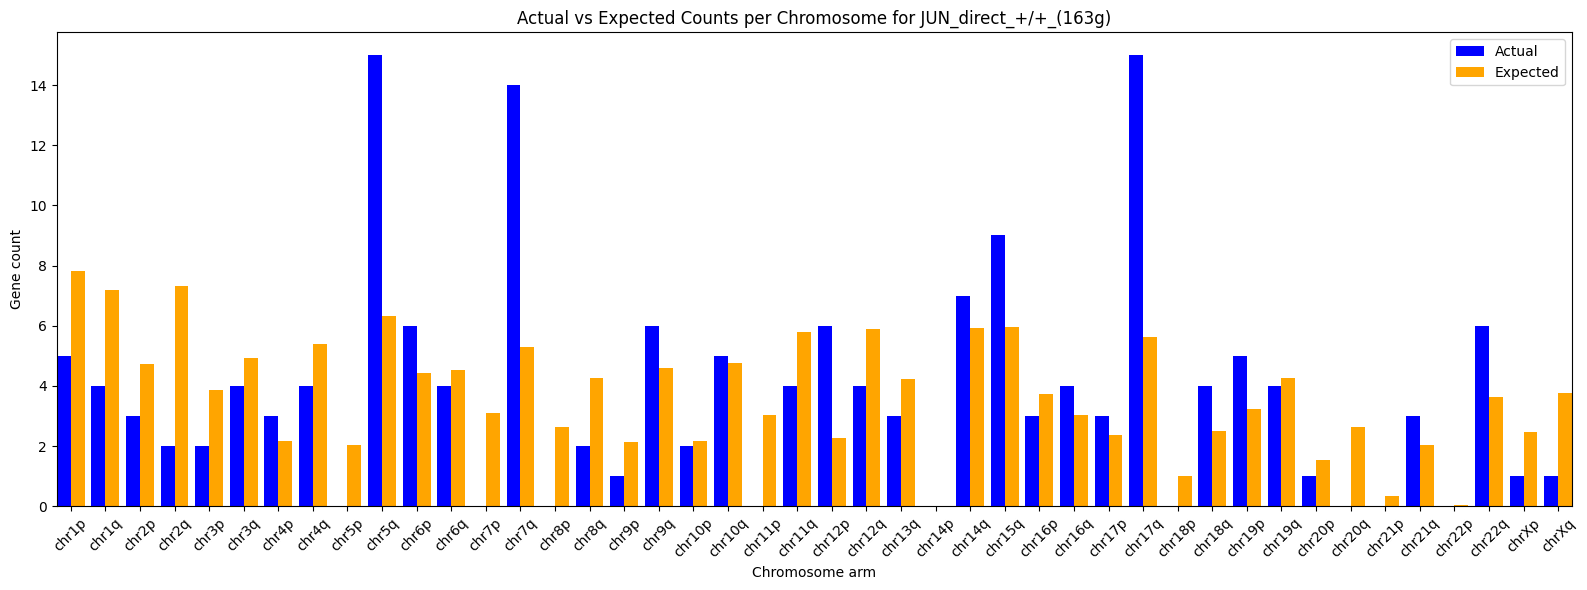

   Chromosome Arm  Actual  Expected  Sample Size  Degrees of Freedom  \
0             1_p       5  7.803840    12.803840                   1   
1             1_q       4  7.196545    11.196545                   1   
2             2_p       3  4.722931     7.722931                   1   
3             2_q       2  7.306578     9.306578                   1   
4             3_p       2  3.872296     5.872296                   1   
5             3_q       4  4.926068     8.926068                   1   
6             4_p       3  2.175257     5.175257                   1   
7             4_q       4  5.397938     9.397938                   1   
8             5_p       0  2.027136     2.027136                   1   
9             5_q      15  6.320518    21.320518                   1   
10            6_p       6  4.433038    10.433038                   1   
11            6_q       4  4.517678     8.517678                   1   
12            7_p       0  3.085140     3.085140                

In [10]:
chromosome_disctribution('JUN_direct_+/+_(163g)',scplus_mdata, genes)

10_p: Actual = 7, Expected = 10.31
10_q: Actual = 28, Expected = 22.63
11_p: Actual = 10, Expected = 14.44
11_q: Actual = 30, Expected = 27.55
12_p: Actual = 10, Expected = 10.78
12_q: Actual = 38, Expected = 28.12
13_q: Actual = 8, Expected = 20.16
14_p: Actual = 0, Expected = 0.01
14_q: Actual = 38, Expected = 28.18
15_q: Actual = 27, Expected = 28.42
16_p: Actual = 24, Expected = 17.73
16_q: Actual = 14, Expected = 14.39
17_p: Actual = 13, Expected = 11.32
17_q: Actual = 55, Expected = 26.76
18_p: Actual = 8, Expected = 4.81
18_q: Actual = 13, Expected = 11.86
19_p: Actual = 27, Expected = 15.45
19_q: Actual = 31, Expected = 20.30
1_p: Actual = 24, Expected = 37.17
1_q: Actual = 12, Expected = 34.28
20_p: Actual = 9, Expected = 7.32
20_q: Actual = 14, Expected = 12.53
21_p: Actual = 0, Expected = 1.69
21_q: Actual = 17, Expected = 9.74
22_p: Actual = 0, Expected = 0.23
22_q: Actual = 21, Expected = 17.38
2_p: Actual = 10, Expected = 22.50
2_q: Actual = 19, Expected = 34.81
3_p: Actu

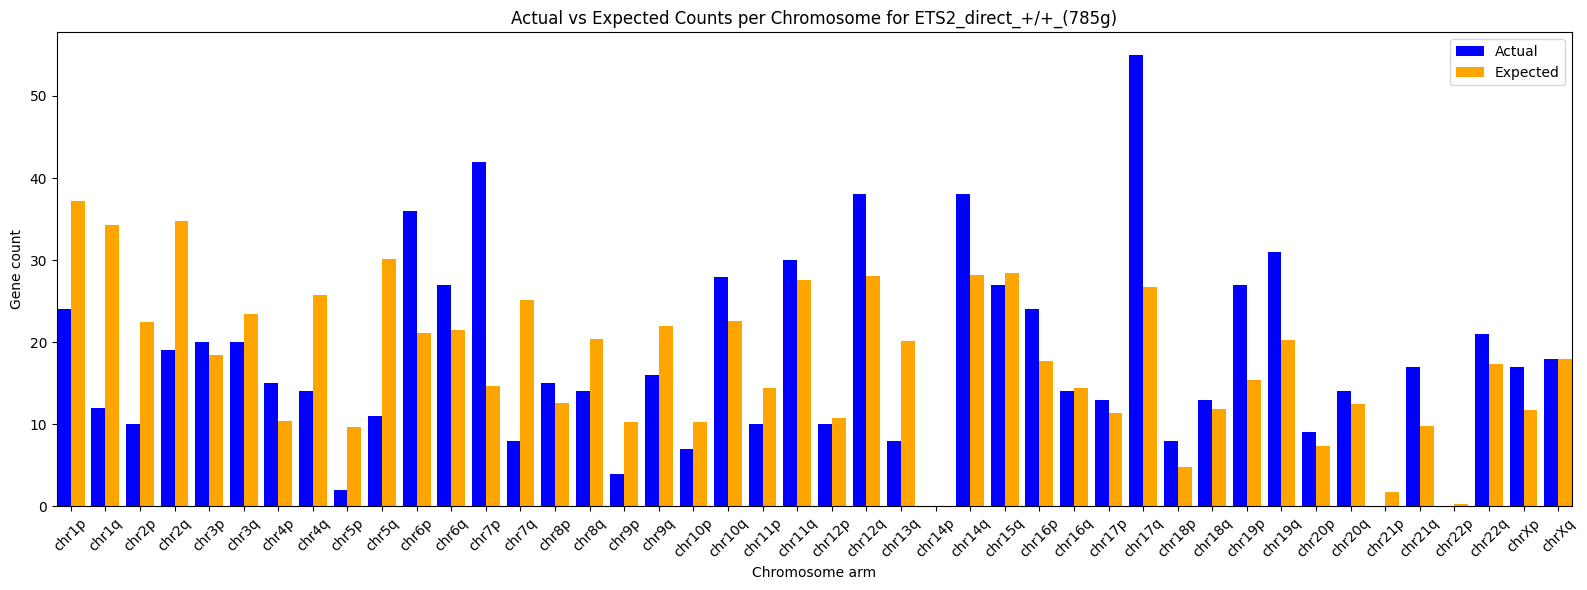

   Chromosome Arm  Actual   Expected  Sample Size  Degrees of Freedom  \
0             1_p      24  37.174654    61.174654                   1   
1             1_q      12  34.281724    46.281724                   1   
2             2_p      10  22.498326    32.498326                   1   
3             2_q      19  34.805879    53.805879                   1   
4             3_p      20  18.446208    38.446208                   1   
5             3_q      20  23.465996    43.465996                   1   
6             4_p      15  10.362132    25.362132                   1   
7             4_q      14  25.713813    39.713813                   1   
8             5_p       2   9.656540    11.656540                   1   
9             5_q      11  30.108647    41.108647                   1   
10            6_p      36  21.117381    57.117381                   1   
11            6_q      27  21.520577    48.520577                   1   
12            7_p      42  14.696487    56.696487  

In [11]:
chromosome_disctribution('ETS2_direct_+/+_(785g)',scplus_mdata, genes)

In [12]:
pip list

Package                              Version
------------------------------------ -----------------
adjustText                           1.0.4
aiohttp                              3.9.3
aiosignal                            1.3.1
anndata                              0.10.5.post1
annoy                                1.17.3
appdirs                              1.4.4
arboreto                             0.1.6
argparse-dataclass                   2.0.0
array_api_compat                     1.5.1
asttokens                            2.4.1
attr                                 0.3.2
attrs                                23.2.0
bbknn                                1.6.0
beautifulsoup4                       4.12.3
bidict                               0.23.1
bioservices                          1.11.2
blosc2                               2.5.1
bokeh                                3.4.0
boltons                              23.1.1
bs4                                  0.0.2
cattrs                     